In [2]:
import scanpy as sc 
import pandas as pd
import numpy as np

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(5, 5), facecolor="white")

-----
anndata     0.9.2
scanpy      1.9.3
-----
PIL                 10.2.0
asciitree           NA
asttokens           NA
awkward             2.3.1
awkward_cpp         NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
entrypoints         0.4
executing           1.2.0
fasteners           0.19
google              NA
h5py                3.7.0
igraph              0.10.8
ipykernel           6.25.0
jedi                0.18.2
joblib              1.3.0
kiwisolver          1.4.4
leidenalg           0.10.1
llvmlite            0.39.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.56.0
numcodecs           0.11.0
numpy               1.22.4
packaging           23.1
pandas              2.0.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pk

In [4]:
adata = sc.read("Concatenato_gex.h5ad")

In [5]:
annotation_dict = {'0': 'TACWT3',
                  '1':'ShamWT3'}
adata.obs['Sample'] = [annotation_dict[clust] for clust in adata.obs['batch']]

In [6]:
adata.obs['Model'] = adata.obs['Condition']
adata.obs['Condition'] = "WT"

In [7]:
annotation_dict = {'SHAM': 'Sham',
                  'TAC':'TAC'}
adata.obs['Model'] = [annotation_dict[clust] for clust in adata.obs['Model']]

In [8]:
adata.obs['Tech'] = "Multiome"

In [9]:
adata_ref = sc.read("/home/lugli/spuccio/Projects/CNR_SP01/scRNAseq/Part3_GEGS.h5ad")

In [10]:
adata_ref.X = adata_ref.layers['raw_counts']

In [11]:
adata_conc = sc.concat([adata_ref,adata])

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [12]:
adata_conc.shape

(28508, 16440)

In [13]:
adata_conc = adata_conc[(adata_conc[: , 'Cdh5'].X.A > 0) & (adata_conc[: , 'Pecam1'].X.A > 0), :]

In [14]:
print(adata_conc.n_obs, adata_conc.n_vars)
malat1 = adata_conc.var_names.str.startswith('Malat1')
ribo_genes = adata_conc.var_names.str.startswith(("Rpl","Rps"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)
adata_conc = adata_conc[:,keep]
print(adata_conc.n_obs, adata_conc.n_vars)

26518 16440
26518 16440


In [15]:
print(adata_conc.n_obs, adata_conc.n_vars)
malat1 = adata_conc.var_names.str.startswith('Malat1')
mito_genes = adata_conc.var_names.str.startswith(("mt-"))
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)
adata_conc = adata_conc[:,keep]
print(adata_conc.n_obs, adata_conc.n_vars)

26518 16440
26518 16440


In [16]:
adata_conc.layers['counts'] = adata_conc.X

In [17]:
adata_conc.to_df().T.to_csv("raw_matrix_count.txt",sep="\t",header=True,index=True)

In [18]:
sc.pp.normalize_total(adata_conc, target_sum = 1e4)
sc.pp.log1p(adata_conc)

In [19]:
adata_conc

AnnData object with n_obs × n_vars = 26518 × 16440
    obs: 'Sample', 'Model', 'Condition', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_genes'
    uns: 'log1p'
    layers: 'counts'

In [20]:
adata_conc.to_df().T.to_csv("log_matrix_count.txt",sep="\t",header=True,index=True)

In [21]:
sc.pp.highly_variable_genes(adata_conc, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [22]:
adata_conc.raw = adata_conc

In [23]:
adata_conc = adata_conc[:,adata_conc.var.highly_variable]

In [24]:
sc.pp.scale(adata_conc,max_value=10)

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:
sc.tl.pca(adata_conc, svd_solver="arpack")

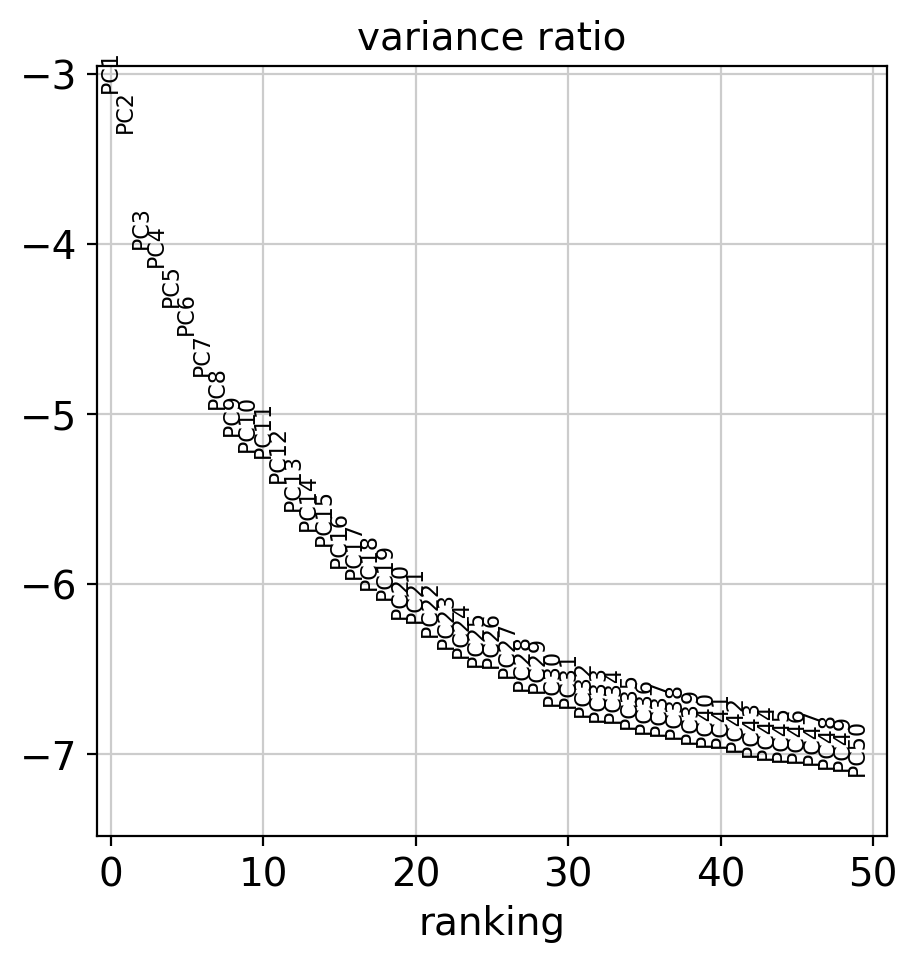

In [26]:
sc.pl.pca_variance_ratio(adata_conc, log=True,n_pcs=50)

In [27]:
sc.pp.neighbors(adata_conc, n_neighbors=10, n_pcs=50)

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
sc.tl.umap(adata_conc)

In [29]:
sc.tl.leiden(
    adata_conc,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)


/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


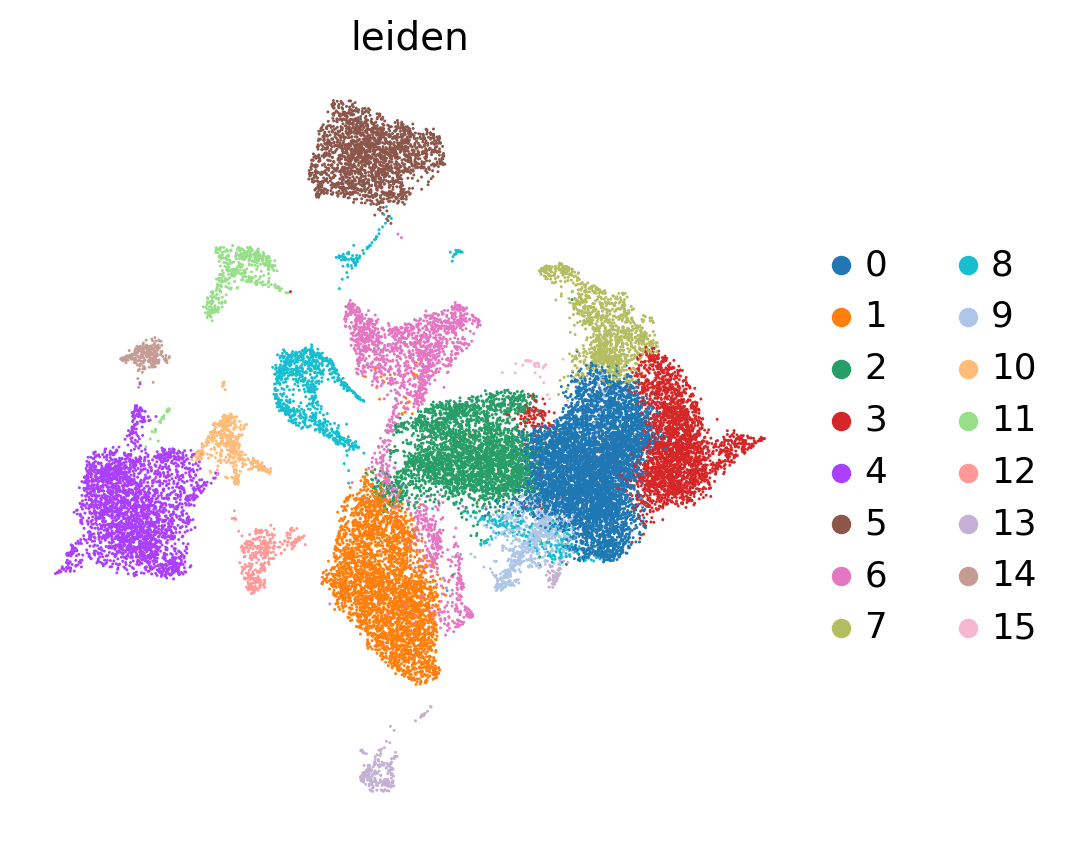

In [30]:
sc.pl.umap(adata_conc, color=["leiden"])

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


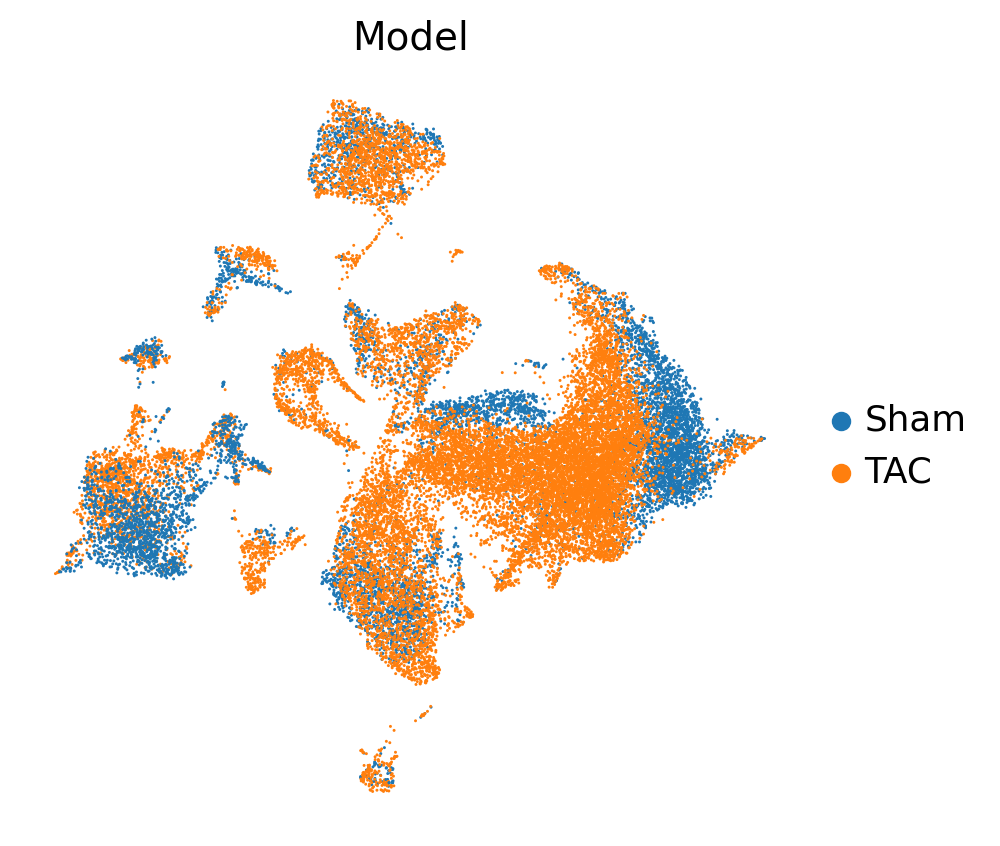

In [31]:
sc.pl.umap(adata_conc, color=["Model"])

In [32]:
annotation_dict2 = {'ShamWT1': 'GEX',
                  'ShamWT2':'GEX',
                  'ShamWT3':'Multiome',
                  'TACWT1':'GEX',
                  'TACWT2':'GEX',
                  'TACWT3':'Multiome'}
adata_conc.obs['Tech'] = [annotation_dict2[clust] for clust in adata_conc.obs['Sample']]

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


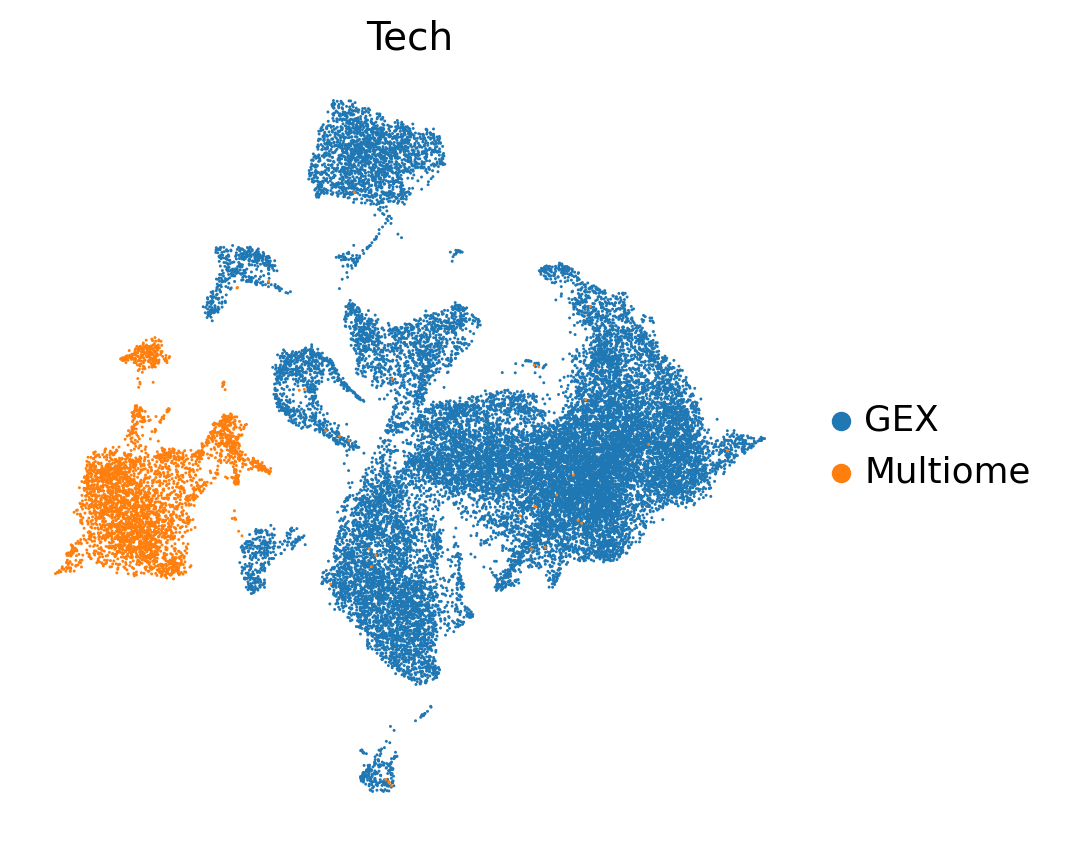

In [33]:
sc.pl.umap(adata_conc, color=["Tech"])

In [34]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata_conc,key=['Tech','Model'])

2024-06-30 12:07:57,967 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-30 12:08:04,840 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-30 12:08:04,925 - harmonypy - INFO - Iteration 1 of 10
2024-06-30 12:08:09,889 - harmonypy - INFO - Iteration 2 of 10
2024-06-30 12:08:15,020 - harmonypy - INFO - Iteration 3 of 10
2024-06-30 12:08:20,091 - harmonypy - INFO - Iteration 4 of 10
2024-06-30 12:08:25,047 - harmonypy - INFO - Iteration 5 of 10
2024-06-30 12:08:29,996 - harmonypy - INFO - Iteration 6 of 10
2024-06-30 12:08:35,129 - harmonypy - INFO - Iteration 7 of 10
2024-06-30 12:08:40,191 - harmonypy - INFO - Iteration 8 of 10
2024-06-30 12:08:45,317 - harmonypy - INFO - Iteration 9 of 10
2024-06-30 12:08:50,454 - harmonypy - INFO - Iteration 10 of 10
2024-06-30 12:08:55,726 - harmonypy - INFO - Stopped before convergence


In [35]:
sc.pp.neighbors(adata_conc, n_neighbors=15, n_pcs=30,use_rep='X_pca_harmony')

In [36]:
sc.tl.umap(adata_conc)

In [37]:
sc.tl.leiden(
    adata_conc,
    resolution=0.8,
    random_state=0,
    n_iterations=2,
    directed=False,
)

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


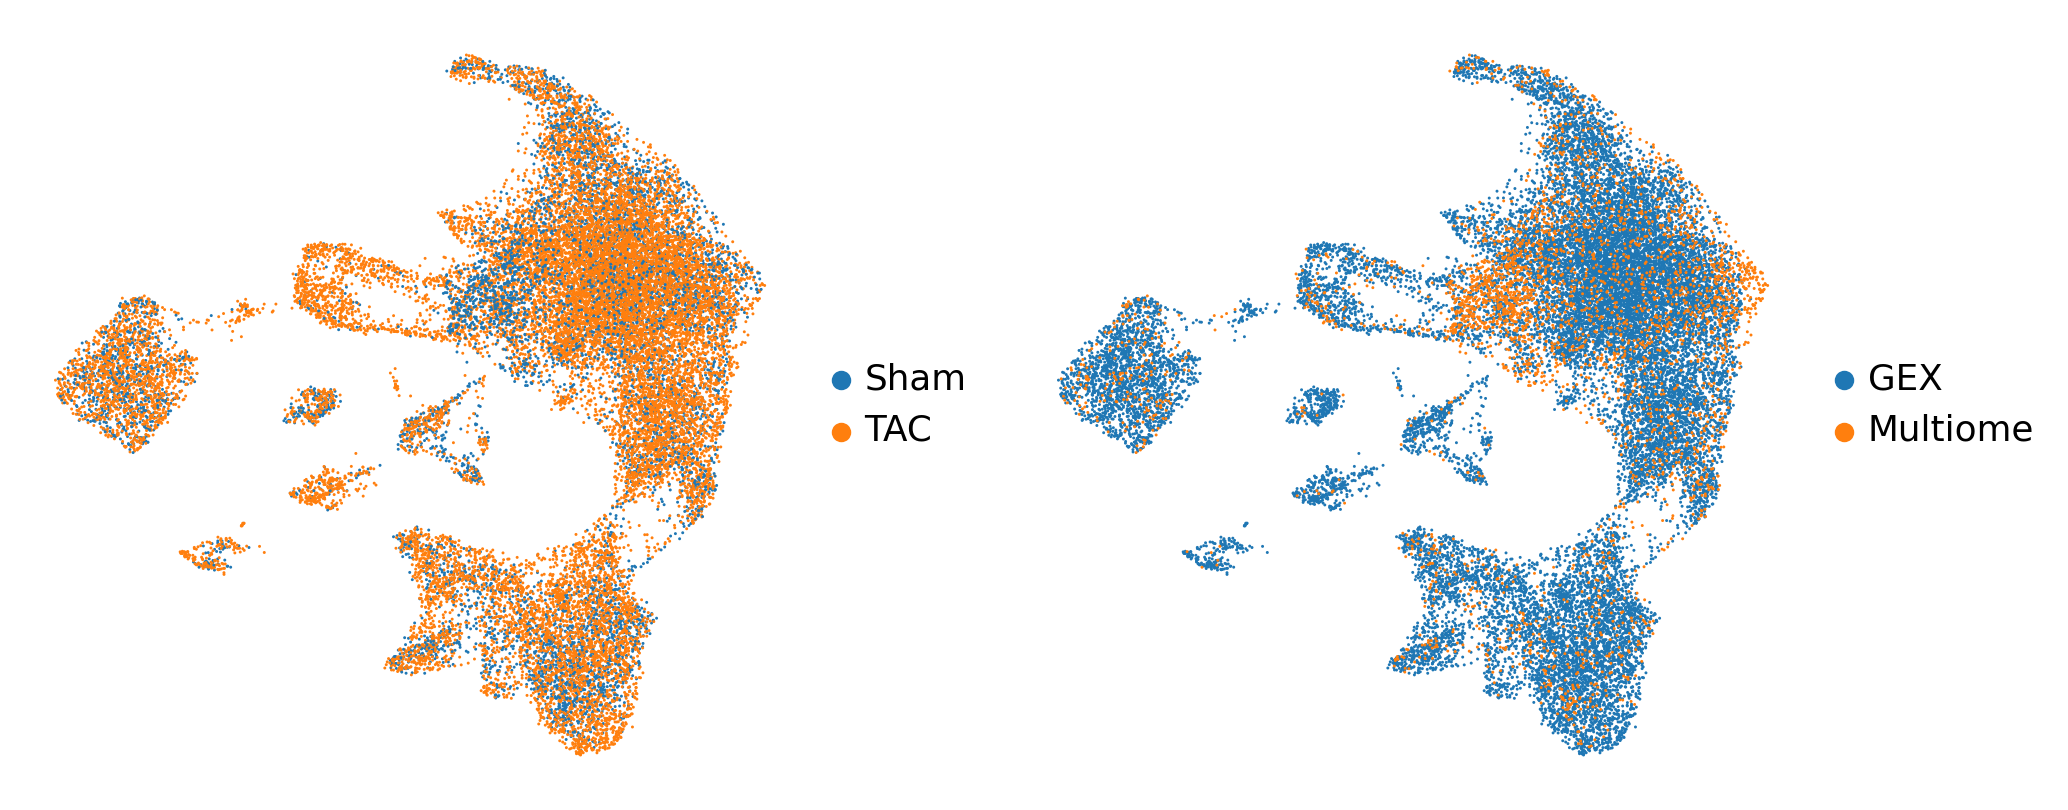

In [42]:
sc.pl.umap(adata_conc, color=["Model","Tech"],add_outline=False,title=["",""],save="umap_clusters2",sort_order=False)

/home/lugli/spuccio/anaconda3/envs/TCR_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


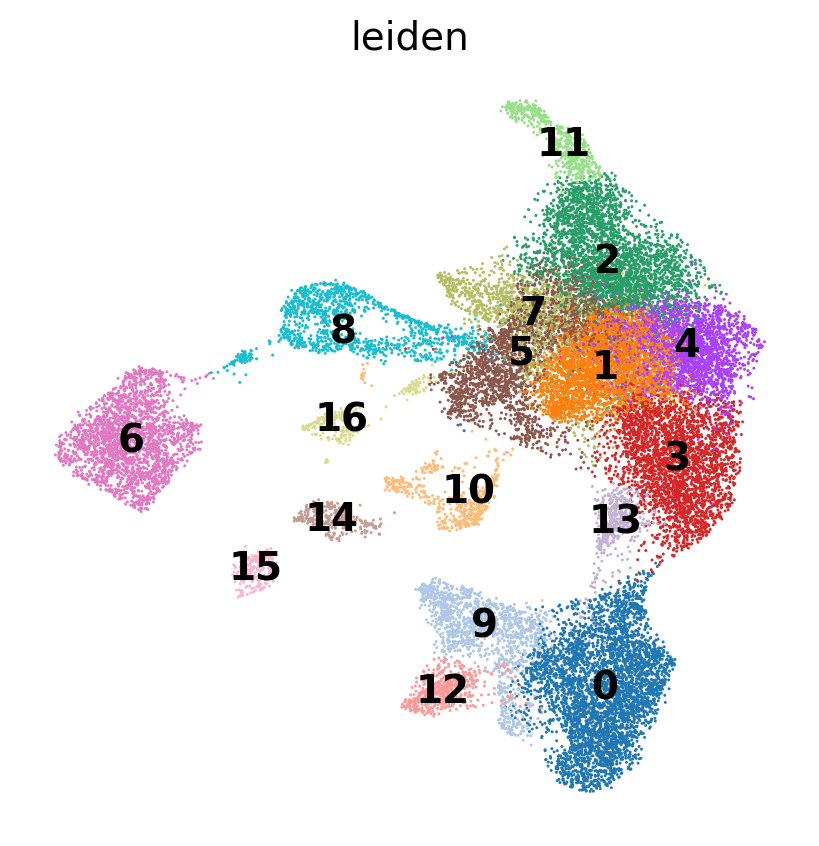

In [37]:
sc.pl.umap(adata_conc, color=["leiden"],legend_loc="on data")

In [36]:
adata_conc.write("Part2_integration.h5ad")